# Single Image Super Resolution using SRGAN

Source : https://ieeexplore.ieee.org/document/8099502 <br>
https://www.kaggle.com/code/balraj98/single-image-super-resolution-gan-srgan-pytorch/notebook

In [1]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

import cv2
print("Imports ready.")

Imports ready.


In [2]:
table = np.array(pd.read_csv('/kaggle/input/mnistdata/mnist_train_small.csv'))
os.makedirs('/kaggle/working/dataset/train/images', exist_ok=True)
os.makedirs('/kaggle/working/dataset/train/labels', exist_ok=True)
i = 0
while i < 19999:
    if not i % 1000:
        print(i)
    img_list = table[i][1:]
    img_label = table[i][0]
    cv2.imwrite('/kaggle/working/dataset/train/images/' + "img_" + str(i) + ".jpg", np.array(img_list).reshape(28,28))
    with open('/kaggle/working/dataset/train/labels/' + "img_" + str(i) + ".txt", 'w') as f:
        f.write(str(img_label))
    i +=1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


In [3]:
table = np.array(pd.read_csv('/kaggle/input/mnistdata/mnist_test.csv'))
os.makedirs('/kaggle/working/dataset/test/images', exist_ok=True)
os.makedirs('/kaggle/working/dataset/test/labels', exist_ok=True)
i = 0
while i < 9999:
    if not i % 1000:
        print(i)
    img_list = table[i][1:]
    img_label = table[i][0]
    cv2.imwrite('/kaggle/working/dataset/test/images/' + "img_" + str(i) + ".jpg", np.array(img_list).reshape(28,28))
    with open('/kaggle/working/dataset/test/labels/' + "img_" + str(i) + ".txt", 'w') as f:
        f.write(str(img_label))
    i +=1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [6]:
# load pretrained models
load_pretrained_models = False
# number of epochs of training
n_epochs = 2
# name of the dataset
dataset_path = '/kaggle/working/dataset/train/images'
# size of the batches
batch_size = 128
# adam: learning rate
lr = 0.00008
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of second order momentum of gradient
b2 = 0.999
# epoch from which to start lr decay
decay_epoch = 100
# number of cpu threads to use during batch generation
n_cpu = 4
# high res. image height
hr_height = 28
# high res. image width
hr_width = 28
# number of image channels
channels = 3

%cd '/kaggle/working/'
os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

cuda = torch.cuda.is_available()
hr_shape = (hr_height, hr_width)
print("Hyperparameters Loaded.")

/kaggle/working
Hyperparameters Loaded.


In [7]:
# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

class ImageDataset(Dataset):
    def __init__(self, files, hr_shape):
        hr_height, hr_width = hr_shape
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height // 2, hr_height // 2), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        self.files = files
    
    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)]).convert('RGB')
        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)
            
        return {"lr": img_lr, "hr": img_hr}
    
    def __len__(self):
        return len(self.files)

print("Image Dataset class created")

Image Dataset class created


In [8]:
train_paths, test_paths = train_test_split(sorted(glob.glob(dataset_path + "/*.*")), test_size=0.02, random_state=42)
train_dataloader = DataLoader(ImageDataset(train_paths, hr_shape=hr_shape), batch_size=batch_size, shuffle=True, num_workers=n_cpu)
test_dataloader = DataLoader(ImageDataset(test_paths, hr_shape=hr_shape), batch_size=int(batch_size*0.75), shuffle=True, num_workers=n_cpu)
print('Dataset loaded and processed.')

Dataset loaded and processed.


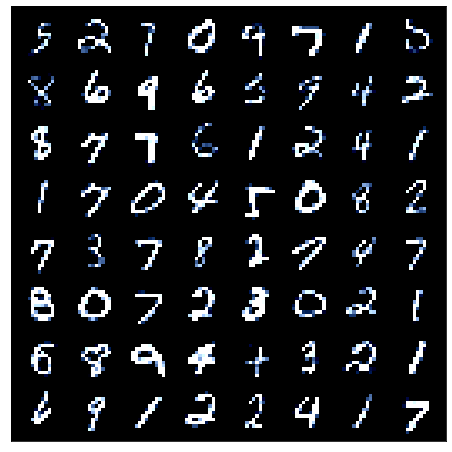

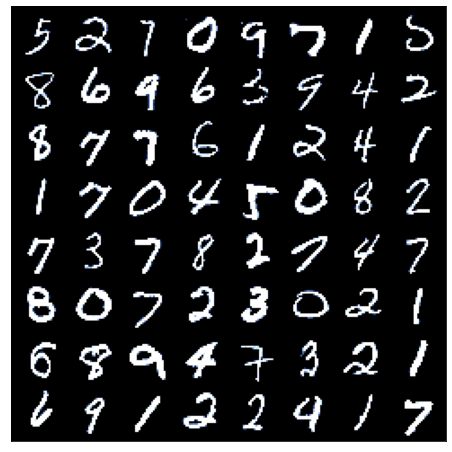

In [9]:
def show_images(images, q, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images[q].detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax=nmax, q='lr')
        show_images(images, nmax=nmax, q='hr')
        break

show_batch(train_dataloader)

In [10]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(progress=False, pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=4):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(1):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

print('Generator and Discriminator classes created.')

Generator and Discriminator classes created.


In [11]:
# Initialize generator and discriminator
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(channels, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

# Load pretrained models
if load_pretrained_models:
    generator.load_state_dict(torch.load("/kaggle/working/saved_models/generator.pth"))
    discriminator.load_state_dict(torch.load("/kaggle/working/saved_models/discriminator.pth"))

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
print('Generator and Discriminator loaded.')

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


Generator and Discriminator loaded.


In [12]:
def to_np(x):
    return x.data.cpu().numpy()

def plot_train_result(real_image, gen_image, recon_image, epoch=1, count = 0, save=False,  show=True, fig_size=(10, 10)):
    fig, axes = plt.subplots(3, 3, figsize=fig_size)
    imgs = [to_np(real_image[0,:,:,:]), to_np(gen_image[0,:,:,:]), to_np(recon_image[0,:,:,:]),
            to_np(real_image[1,:,:,:]), to_np(gen_image[1,:,:,:]), to_np(recon_image[1,:,:,:]),
            to_np(real_image[2,:,:,:]), to_np(gen_image[2,:,:,:]), to_np(recon_image[2,:,:,:])]
    
    for ax, img in zip(axes.flatten(), imgs):
        ax.axis('off')
        #ax.set_adjustable('box-forced')
        # Scale to 0-255
        img = img.squeeze()
        img = np.transpose((((img - img.min()) * 255) / (img.max() - img.min())), axes=[1,2,0]).astype(np.uint8)
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)

    title = 'Epoch_{0}'.format(epoch + 1) + '_count_{:d}'.format(count+1)
    fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        save_fn = 'Result_epoch_{:d}'.format(epoch+1) + '_count_{:d}'.format(count+1) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()

print('Plotting functions created.')

Plotting functions created.


Training Epoch 0 :   0%|          | 0/154 [00:00<?, ?it/s]

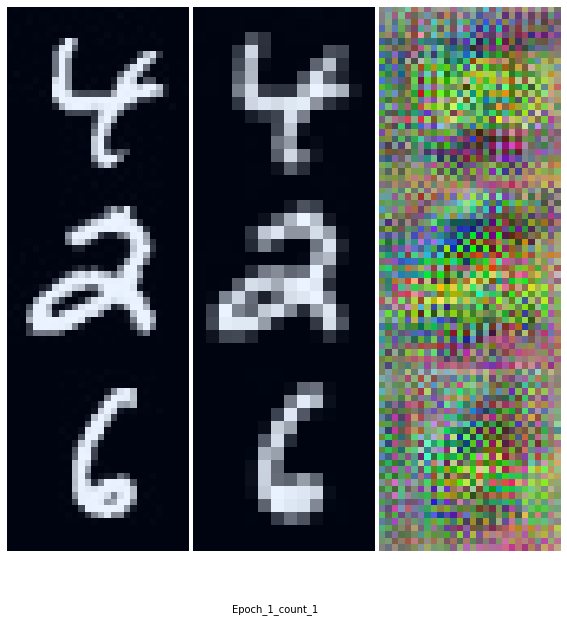

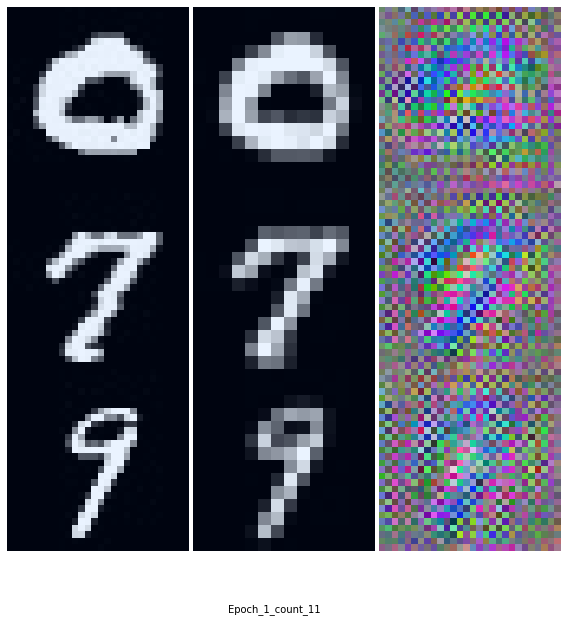

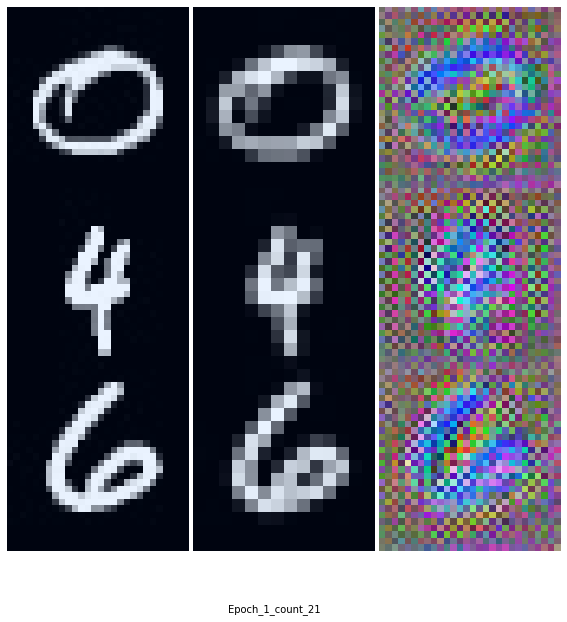

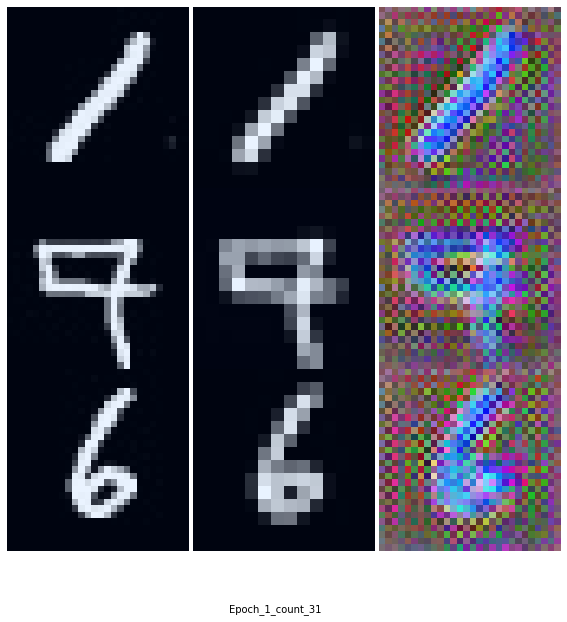

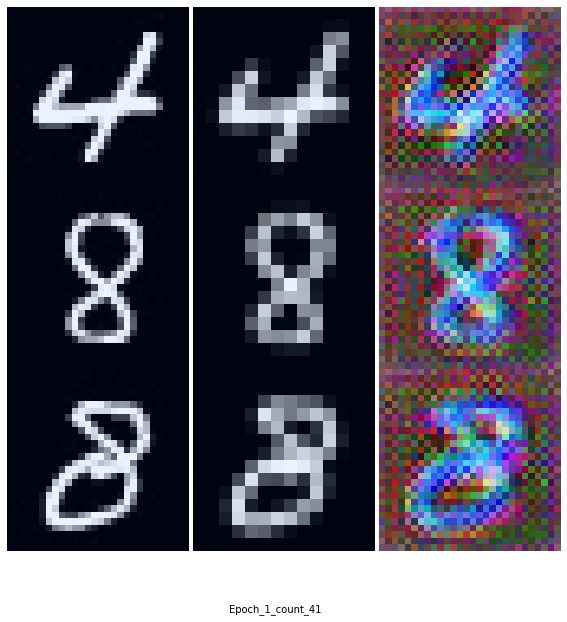

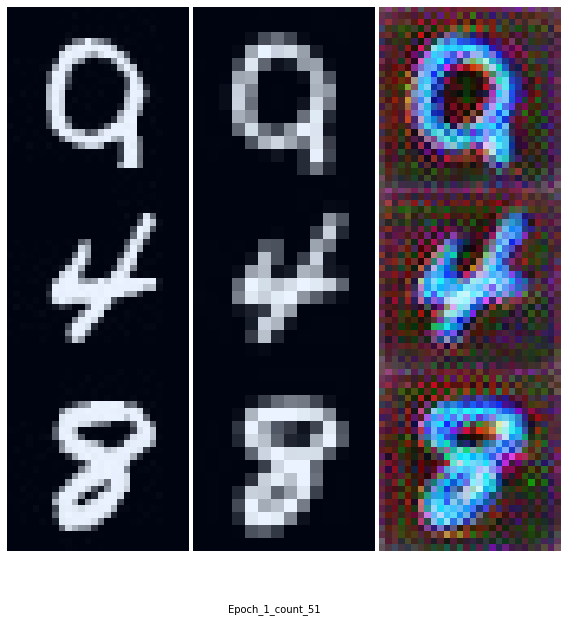

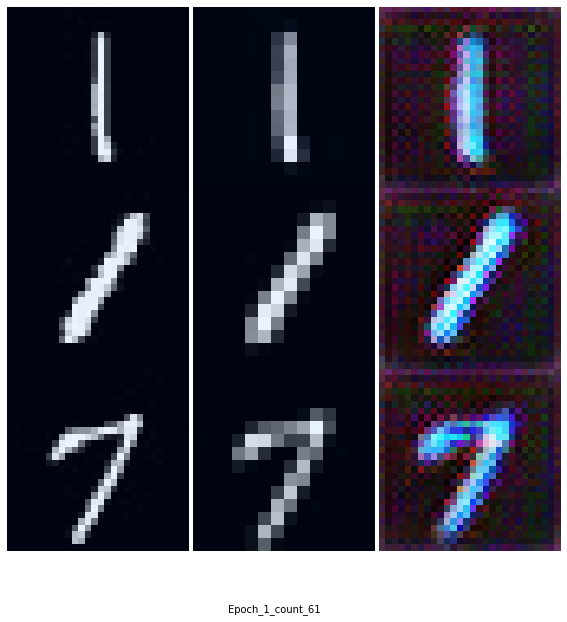

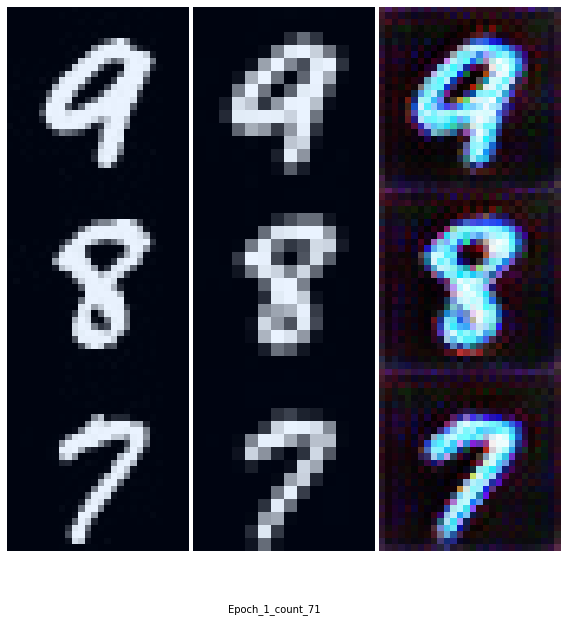

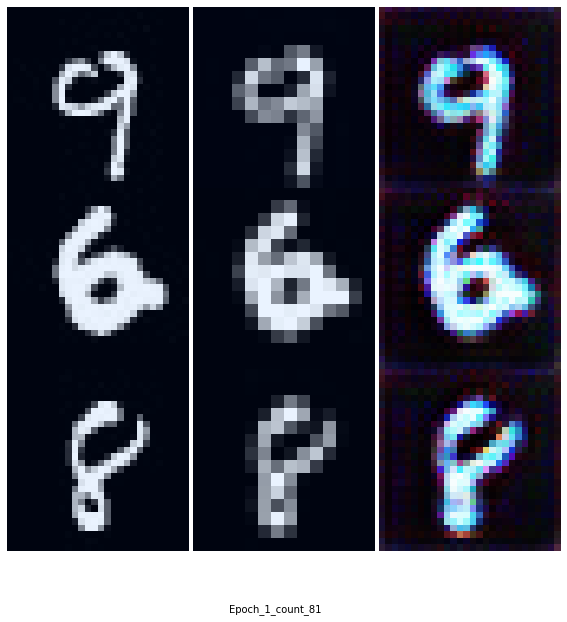

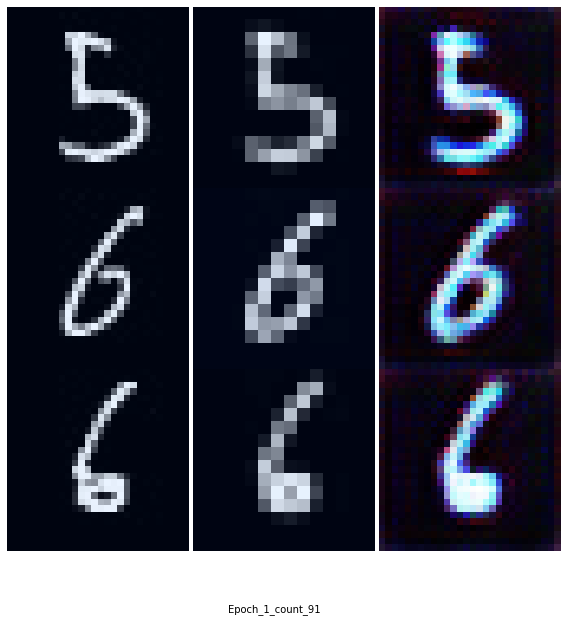

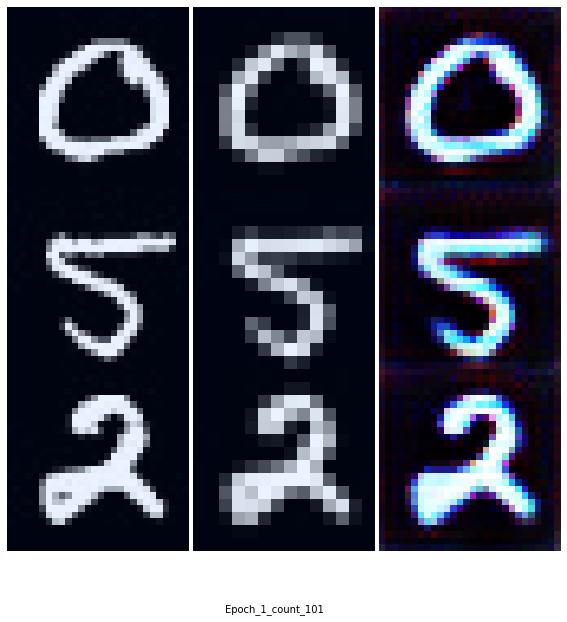

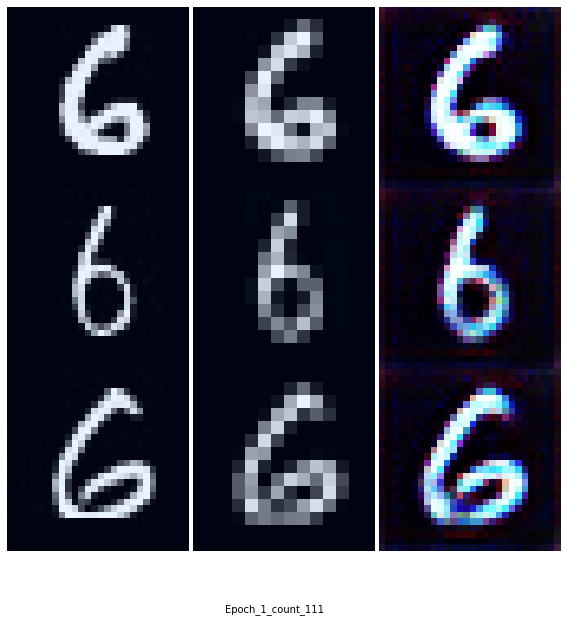

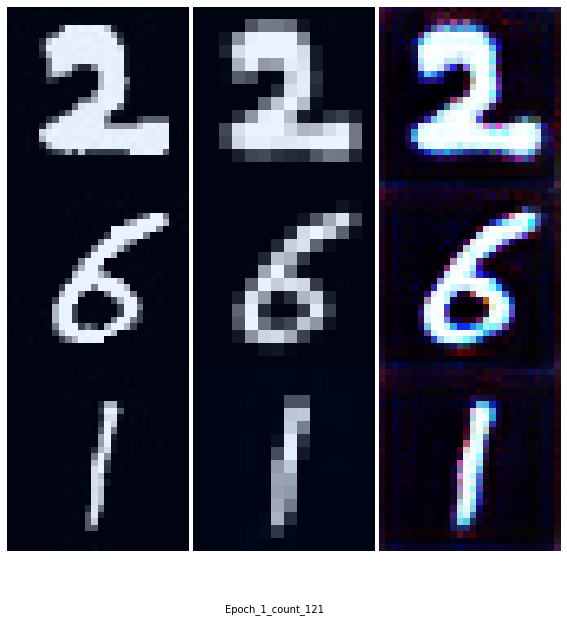

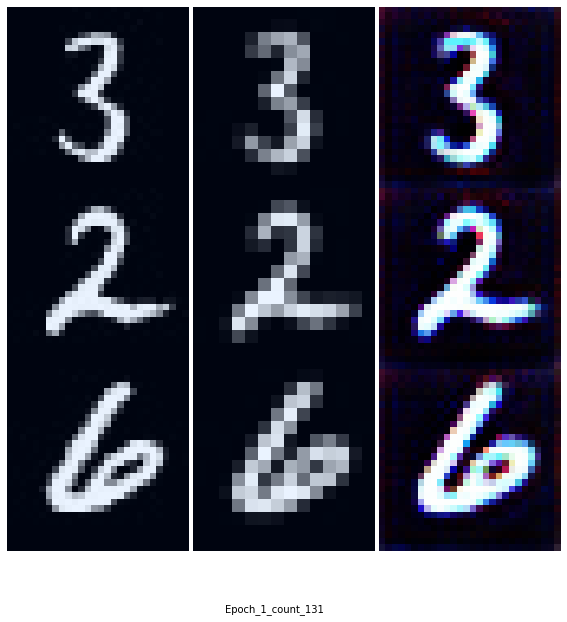

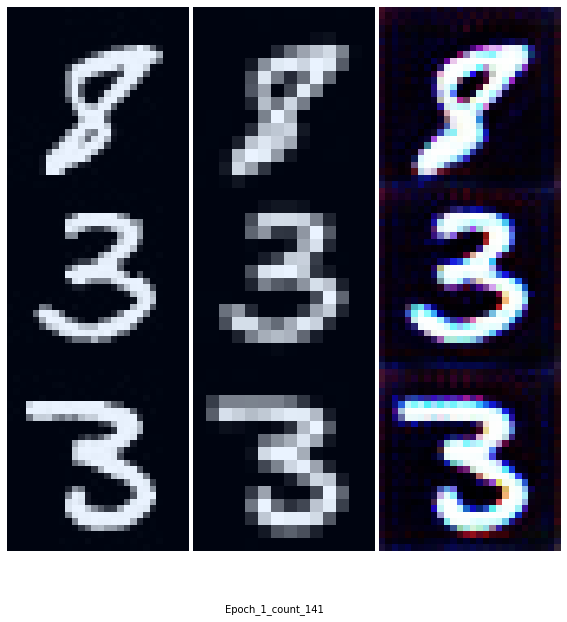

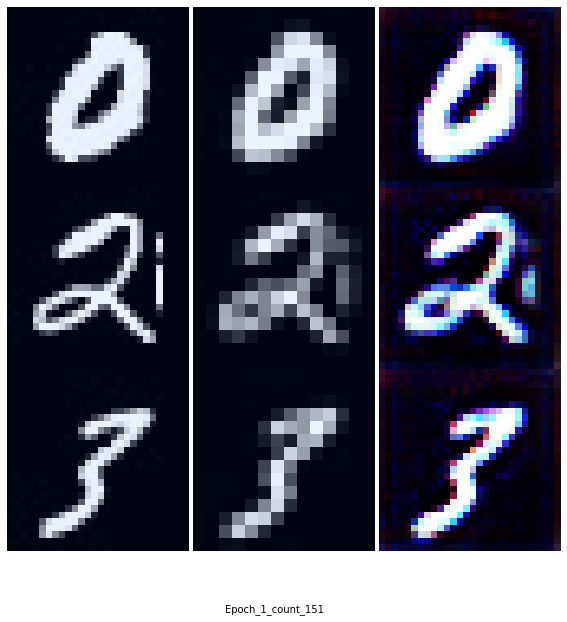

In [13]:
train_gen_losses, train_disc_losses, train_counter = [], [], []
test_gen_losses, test_disc_losses = [], []
test_counter = [idx*len(train_dataloader.dataset) for idx in range(1, n_epochs+1)]
#BA = -1000

for epoch in range(1):
    count = 0
    ### Training
    gen_loss, disc_loss = 0, 0
    tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=int(len(train_dataloader)))
    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.train()
        discriminator.train()
        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))
        
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        
        
        ### Train Generator
        optimizer_G.zero_grad()
        
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)
        #gen.append(gen_hr)
        
        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
        
        
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        
        loss_content = criterion_content(gen_features, real_features)

        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN
        loss_G.backward()
        optimizer_G.step()
        
  
        
        if(count%10 == 0):
            plot_train_result(imgs_hr, imgs_lr, gen_hr, count = count, epoch = epoch) 
            pass
            
        count = count+1    

        ### Train Discriminator
        optimizer_D.zero_grad()
        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        gen_loss += loss_G.item()
        train_gen_losses.append(loss_G.item())
        disc_loss += loss_D.item()
        train_disc_losses.append(loss_D.item())
        train_counter.append(batch_idx*batch_size + imgs_lr.size(0) + epoch*len(train_dataloader.dataset))
        tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))

        
        # Save image grid with upsampled inputs and SRGAN outputs
        if (count%10==0):
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=2)
            imgs_hr = make_grid(imgs_hr[0:3], nrow=1, normalize=True)
            gen_hr = make_grid(gen_hr[0:3], nrow=1, normalize=True)
            imgs_lr = make_grid(imgs_lr[0:3], nrow=1, normalize=True)
            img_grid = torch.cat((imgs_hr, imgs_lr, gen_hr), -1)
            save_image(img_grid, f"images/{batch_idx+1}.png", normalize=False)

            
        
        # Save model checkpoints
        if np.argmin(train_gen_losses) == len(train_gen_losses)-1:
            torch.save(generator.state_dict(), "saved_models/generator.pth")
            torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")

        

In [15]:
import os
os.chdir(r'/kaggle/working')

!zip -r images.zip /kaggle/working/images

from IPython.display import FileLink

FileLink(r'images.zip')

  adding: kaggle/working/images/ (stored 0%)
  adding: kaggle/working/images/30.png (stored 0%)
  adding: kaggle/working/images/120.png (stored 0%)
  adding: kaggle/working/images/80.png (stored 0%)
  adding: kaggle/working/images/150.png (stored 0%)
  adding: kaggle/working/images/40.png (stored 0%)
  adding: kaggle/working/images/140.png (stored 0%)
  adding: kaggle/working/images/110.png (stored 0%)
  adding: kaggle/working/images/100.png (stored 0%)
  adding: kaggle/working/images/70.png (stored 0%)
  adding: kaggle/working/images/130.png (stored 0%)
  adding: kaggle/working/images/50.png (stored 0%)
  adding: kaggle/working/images/60.png (stored 0%)
  adding: kaggle/working/images/90.png (stored 0%)
  adding: kaggle/working/images/10.png (stored 0%)
  adding: kaggle/working/images/20.png (stored 0%)


/kaggle/working/images.zip

In [16]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_gen_losses, mode='lines', name='Train Generator Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_gen_losses, marker_symbol='star-diamond', 
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Generator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Generator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial + Content Loss"),
fig.show()

In [17]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_disc_losses, mode='lines', name='Train Discriminator Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_disc_losses, marker_symbol='star-diamond', 
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Discriminator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Discriminator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial Loss"),
fig.show()

In [18]:
#MSE error to check
a = 0
for data in test_dataloader:
    a += torch.nn.functional.mse_loss(data['hr'], generator(data['lr']))
    b = data['lr']
    c = data['hr']
    
print(a)

tensor(6.2090, grad_fn=<AddBackward0>)


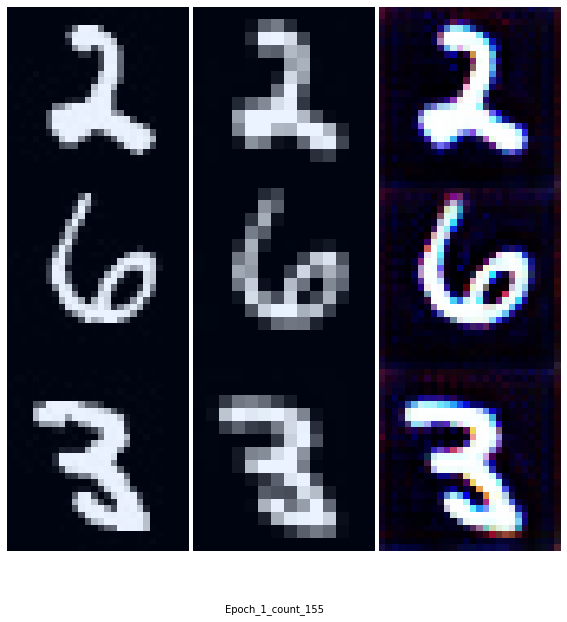

In [19]:
plot_train_result(c, b, generator(b), count = count, epoch = epoch) 